In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install einops

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 130 kB/s 


In [ ]:
import os
import time
import PIL
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets

from tqdm.notebook import tqdm

from einops import rearrange
from einops.layers.torch import Rearrange

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


In [ ]:
root_path = './drive/MyDrive/cityscapes_data'

data_dir = root_path

train_dir = os.path.join(data_dir, "train")

val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)

val_fns = os.listdir(val_dir)

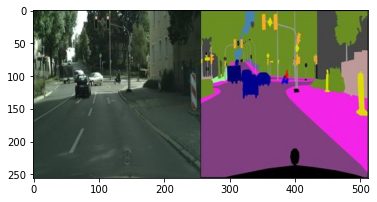

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])

sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [ ]:
# num_items = 1000

# # 0~255 사이의 숫자를 3*num_items번 랜덤하게 뽑기
# color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
# print(color_array.shape)

In [ ]:
# num_classes = 10

# # K-means clustering 알고리즘을 사용하여 label_model에 저장합니다.
# label_model = KMeans(n_clusters = num_classes)
# label_model.fit(color_array)

In [ ]:
color_array = np.array([(0, 0, 0), (0, 0, 70), (0, 0, 90), (0, 0, 110), (0, 0, 142), (0, 0, 230), (0, 60, 100), (0, 80, 100), (70, 70, 70), (70, 130, 180), (81, 0, 81), (102, 102, 156), (107, 142, 35), (111, 74, 0), (119, 11, 32), (128, 64, 128), (150, 100, 100), (150, 120, 90), (152, 251, 152), (153, 153, 153), (180, 165, 180), (190, 153, 153), (220, 20, 60), (220, 220, 0), (230, 150, 140), (244, 35, 232), (250, 170, 30), (250, 170, 160), (255, 0, 0)])
num_classes = 29
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=29)

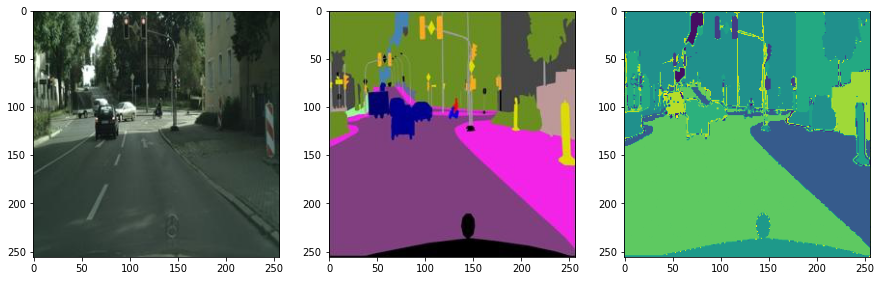

In [ ]:
# 이전에 샘플이미지에서 볼 수 있듯이, original image와 labeled image가 연결되어 있는데 이를 분리해줍니다.
def split_image(image) :
   image = np.array(image)
   
   # 이미지의 크기가 256 x 512 였는데 이를 original image와 labeled image로 분리하기 위해 리스트로 슬라이싱 합니다.
   # 그리고 분리된 이미지를 각각 cityscape(= original image)와 label(= labeled image)에 저장합니다.
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label


# 바로 이전 코드에서 정의한 split_image() 함수를 이용하여 sample_image를 분리한 후, cityscape과 label에 각각 저장합니다.
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [ ]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model
    
  def __len__(self) :
    return len(self.image_fns)
    
  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class
    
  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label
    
  def transform(self, image) :
    transform_ops = transforms.Compose([
      			        transforms.ToTensor(),
                    transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [ ]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


In [ ]:
def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )

class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)

In [ ]:
class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x

In [ ]:
class Convblock(nn.Module):
    
      def __init__(self,input_channel,output_channel,kernal=1,stride=1):
            
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )
    

      def forward(self,x):
        x = self.convblock(x)
        return x

In [ ]:
class CoAtUNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=29, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s = Convblock(in_channels,channels[0])

        self.s0 = self._make_layer(
            conv_3x3_bn, channels[0], channels[1], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[1], channels[2], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[2], channels[3], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[3], channels[4], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[4], channels[5], num_blocks[4], (ih // 32, iw // 32))
        
        self.neck = nn.Conv2d(channels[5],channels[6],1,1)
        self.upconv5 = nn.ConvTranspose2d(channels[6],channels[5],3,2,0,1)
        self.dconv5 = Convblock(2*channels[5],channels[5])
        self.upconv4 = nn.ConvTranspose2d(channels[5],channels[4],3,2,0,1)
        self.dconv4 = Convblock(2*channels[4],channels[4])
        self.upconv3 = nn.ConvTranspose2d(channels[4],channels[3],3,2,0,1)
        self.dconv3 = Convblock(2*channels[3],channels[3])
        self.upconv2 = nn.ConvTranspose2d(channels[3],channels[2],3,2,0,1)
        self.dconv2 = Convblock(2*channels[2],channels[2])
        self.upconv1 = nn.ConvTranspose2d(channels[2],channels[1],3,2,0,1)
        self.dconv1 = Convblock(2*channels[1],channels[1])
        self.upconv0 = nn.ConvTranspose2d(channels[1],channels[0],3,2,0,1)
        self.dconv0 = Convblock(2*channels[0],channels[0])
        self.out = nn.Conv2d(channels[0],num_classes,1,1)

    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transforms.CenterCrop([H,W])(input_tensor)
        
    def forward(self, x):
        # print('x: ', x.shape)
        x0 = self.s(x)
        # print('x0: ', x0.shape)
        x1 = self.s0(x0)
        # print('x1: ', x1.shape)
        x2 = self.s1(x1)
        # print('x2: ', x2.shape)
        x3 = self.s2(x2)
        # print('x3: ', x3.shape)
        x4 = self.s3(x3)
        # print('x4: ', x4.shape)
        x5 = self.s4(x4)
        # print('x5: ', x5.shape)

        neck = self.neck(x5)
        # print('neck: ', neck.shape)
        
        upconv5 = self.upconv5(neck)
        # print('upconv5: ', upconv5.shape)
        croped = self.crop(upconv5, x5)
        # print('croped: ', croped.shape)
        dconv5 = self.dconv5(torch.cat([croped,x5],1))
        # print('dconv5: ', dconv5.shape)
        upconv4 = self.upconv4(dconv5)
        # print('upconv4: ', upconv4.shape)
        croped = self.crop(upconv4, x4)
        # print('croped: ', croped.shape)
        dconv4 = self.dconv4(torch.cat([croped,x4],1))
        # print('dconv4: ', dconv4.shape)
        upconv3 = self.upconv3(dconv4)
        # print('upconv3: ', upconv3.shape)
        croped = self.crop(upconv3, x3)
        # print('croped: ', croped.shape)
        dconv3 = self.dconv3(torch.cat([croped,x3],1))
        # print('dconv3: ', dconv3.shape)
        upconv2 = self.upconv2(dconv3)
        # print('upconv2: ', upconv2.shape)
        croped = self.crop(upconv2,x2)
        # print('croped: ', croped.shape)
        dconv2 = self.dconv2(torch.cat([croped,x2],1))
        # print('dconv2: ', dconv2.shape)
        upconv1 = self.upconv1(dconv2)
        # print('upconv1: ', upconv1.shape)
        croped = self.crop(upconv1,x1)
        # print('croped: ', croped.shape)
        dconv1 = self.dconv1(torch.cat([croped,x1],1))
        # print('dconv1: ', dconv1.shape)
        upconv0 = self.upconv0(dconv1)
        # print('upconv0: ', upconv0.shape)
        croped = self.crop(upconv0, x0)
        # print('croped: ', croped.shape)
        dconv0 = self.dconv0(torch.cat([croped,x0],1))
        # print('dconv0: ', dconv0.shape)
        out = self.out(dconv0)
        # print('out: ', out.shape)

        return out
        

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)

In [ ]:
model = CoAtUNet(
    image_size=(256, 256), 
    in_channels=3, 
    num_blocks=[2, 2, 3, 5, 2], # tuning
    channels=[24, 48, 96, 192, 384, 768, 1536], # tuning
    num_classes=29,
    block_types=['C', 'C', 'T', 'T']) # tuning
model.to(device)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CoAtUNet(
  (s): Convblock(
    (convblock): Sequential(
      (0): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
      (4): ReLU(inplace=True)
    )
  )
  (s0): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate=none)
    )
    (1): Sequential(
      (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate=none)
    )
  )
  (s1): Sequential(
    (0): MBConv(
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (proj): Conv2d(20, 30, 

In [ ]:
batch_size = 32 # tuning

epochs = 10 # tuning
lr = 0.01 # tuning

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0

  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    # print('Y: ', Y.shape)
    # print('Y_pred: ', Y_pred.shape)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print(len(epoch_losses))
print(epoch_losses)

0
[]


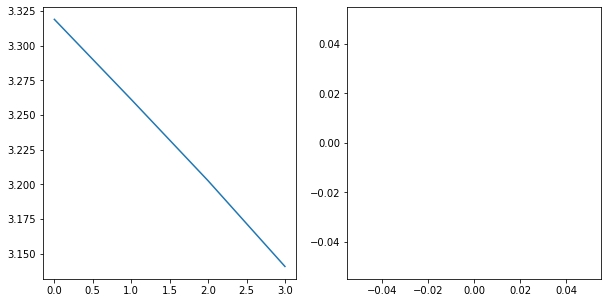

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

plt.show()

In [ ]:
# model_name = "UNet.pth"
# model_path = root_path + model_name
# torch.save(model.state_dict(), model_path)

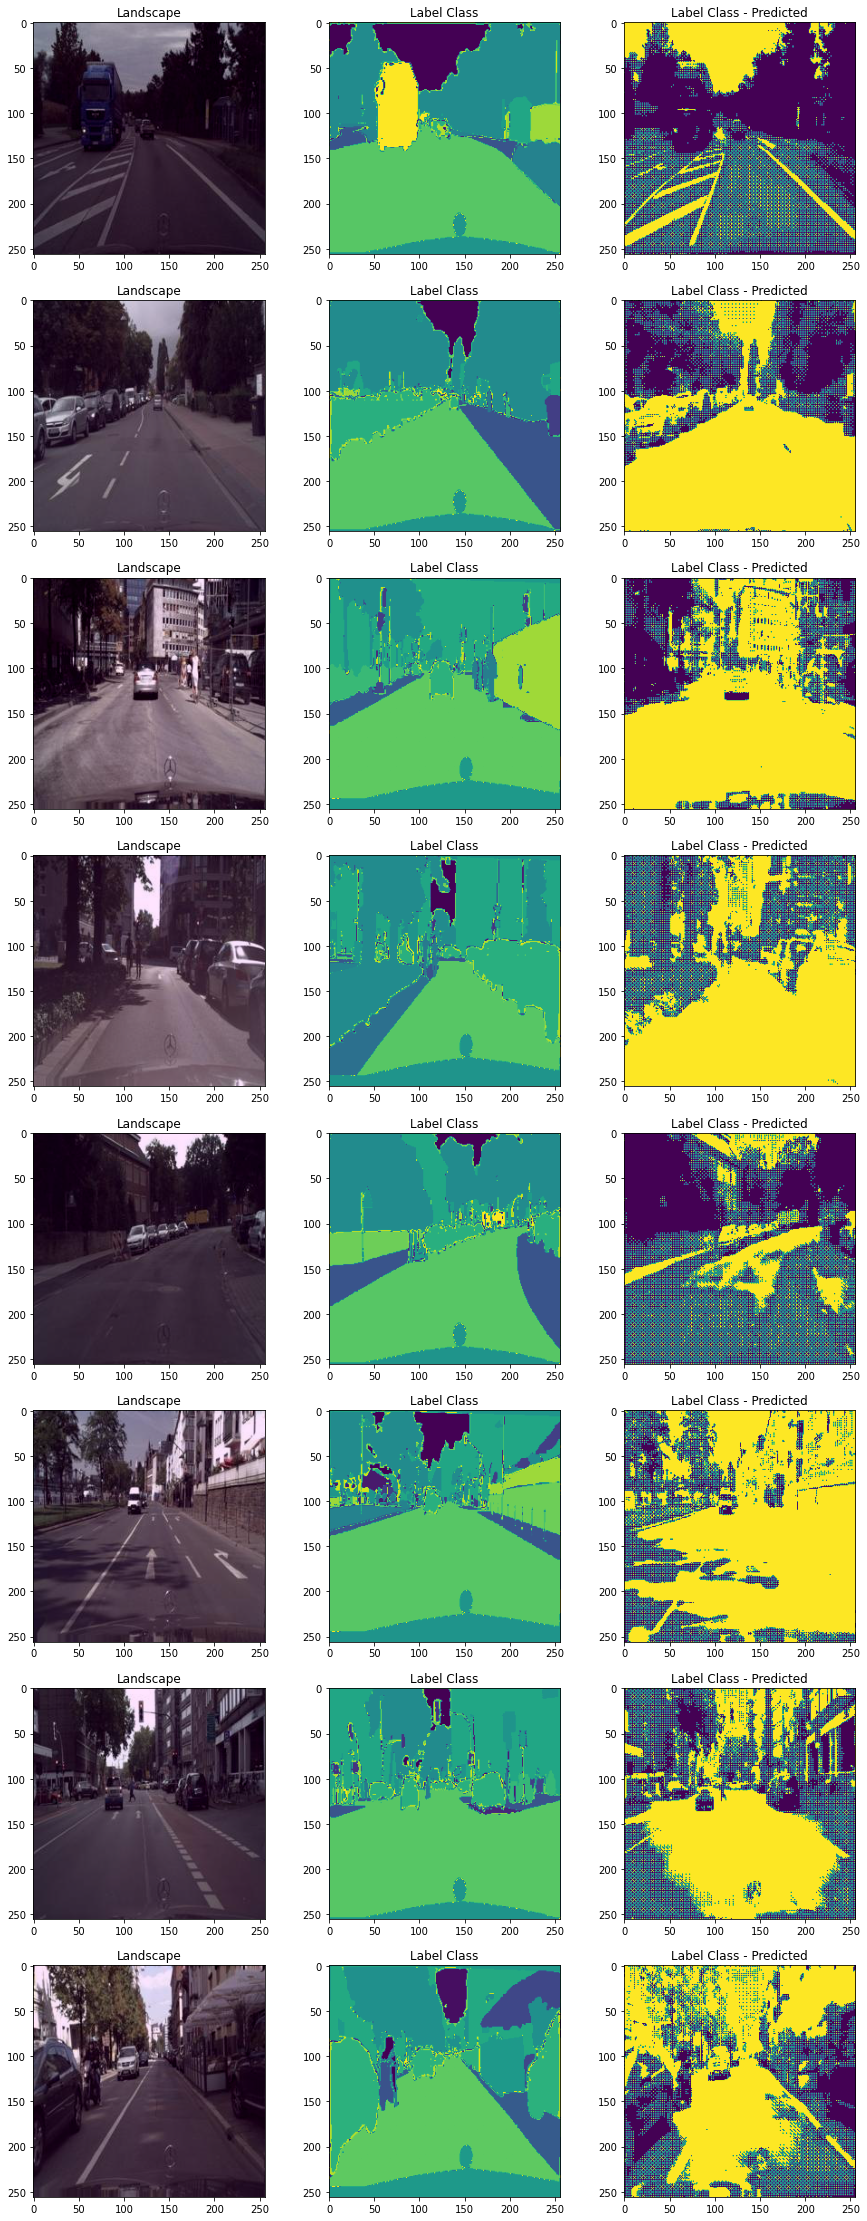

In [ ]:
test_print_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_print_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model(X)
Y_pred = torch.argmax(Y_pred, dim=1)

inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_print_size, 3, figsize=(3*5, test_print_size*5))

for i in range(test_print_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

In [ ]:
def miou(actual, predict, num_classes):
  categories = num_classes * actual + predict
  categories_bins = np.bincount(categories.reshape(-1), minlength=num_classes**2)
  categories_reshape = categories_bins.reshape(num_classes,num_classes)
  categories_sum0 = categories_reshape.sum(axis=0)
  categories_sum1 = categories_reshape.sum(axis=1)
  intersection = []
  union = []
  for class_num in range(num_classes):
    i = categories_reshape[class_num,class_num]
    u = categories_sum0[class_num] + categories_sum1[class_num] - i
    if (u != 0):
      intersection.append(i)
      union.append(u)
  iou = np.array(intersection) / np.array(union)
  m = np.mean(iou)
  return m

In [ ]:
test_batch_size = 4
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)
miou_scores = []
for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
  X, Y = X.to(device), Y.to(device)
  Y_pred = model(X)
  Y_pred = torch.argmax(Y_pred, dim=1)
  for i in range(test_batch_size):
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    miou_score = miou(label_class, label_class_predicted, 29)
    miou_scores.append(miou_score)
print(len(miou_scores))
print(miou_scores)
print(np.mean(miou_scores))

  0%|          | 0/125 [00:00<?, ?it/s]

500
[0.012776725311470916, 0.019036286952977013, 0.02118557384601272, 0.011853749374907465, 0.015492407812231778, 0.015712040739785712, 0.01908545392650746, 0.015836529443488952, 0.014802664813977568, 0.013687109228172904, 0.01504114124651826, 0.0160042297966325, 0.017175612231896866, 0.02404936743851308, 0.006568302404176439, 0.021848063275322425, 0.009796307404244373, 0.019842629278342756, 0.011381624305422408, 0.008709462484516617, 0.018906535071205884, 0.015738510689690434, 0.009871807281639338, 0.016355684824651547, 0.014059534206890982, 0.022643029832498256, 0.014008387601247516, 0.017646654643581908, 0.01944634377364935, 0.01965157679451051, 0.004662114018548321, 0.011901192541819474, 0.016869926606862404, 0.00791014233881963, 0.018976860559387656, 0.009169979091614095, 0.011118532420294812, 0.02001076614082576, 0.0077419364292287225, 0.011929798724109857, 0.01780704083887547, 0.02017105386979857, 0.012050029558281614, 0.011995824346204467, 0.018753758802561943, 0.01484134888360